# Loading data and libraries

In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from bertopic import BERTopic
import nltk
nltk.download('stopwords')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from summarizer import TransformerSummarizer # For GPT2, XLNet
from summarizer import Summarizer # For GPT2, XLNet
from nltk.corpus import stopwords;
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from keybert import KeyBERT
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics.pairwise import cosine_similarity
from bertopic.vectorizers import ClassTfidfTransformer
from nltk.stem.wordnet import WordNetLemmatizer
import re
from collections import defaultdict
from nltk.corpus import wordnet as wn

words = set(nltk.corpus.words.words());
stop_words = nltk.corpus.stopwords.words("english")

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV;

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-01-23 16:27:04.445288: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 16:27:04.526419: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-23 16:27:04.529747: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.c

In [2]:
def get_bert_topics(BERTopic_model, num_topics):
    word_dict = {}
    for i in range(num_topics):
        words=BERTopic_model.get_topic(i)
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
    return pd.DataFrame(word_dict)

def create_wordcloud(BERTopic_model, topic):
    text = {word: value for word, value in BERTopic_model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic"+" "+ str(topic))
    plt.show()
    
def rescale(x, inplace=False):
    """ Rescale an embedding so optimization will not have convergence issues."""
    if not inplace:
        x = np.array(x, copy=True)
    x /= np.std(x[:, 0]) * 10000
    return x

In [55]:
df = pd.read_csv(filepath_or_buffer = "./data_leftwing_cleaned2.csv", delimiter=",", lineterminator='\n')
docs = df["body"].dropna().values.tolist()[0:1000]

# Extracting topics

In [29]:
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(docs, show_progress_bar=False)

In [30]:
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', prediction_data=True)

pca_embeddings = rescale(PCA(n_components=5).fit_transform(embeddings))
umap_model = UMAP(
    n_neighbors=15,
    n_components=5, # otherwise 10
    min_dist=0.0,
    metric="cosine",
    init=pca_embeddings, 
    low_memory=False)

In [31]:
ctfidf_model = ClassTfidfTransformer(bm25_weighting=True) #eventually false

In [32]:
BERTopic_model = BERTopic(umap_model=umap_model, 
                          hdbscan_model=hdbscan_model, 
                          ctfidf_model=ctfidf_model, 
                          embedding_model=sentence_model, 
                          #diversity=0.2,
                          #seed_topic_list=seed_topic_list
                         )

In [33]:
run = True
if run:
    topics, probs = BERTopic_model.fit_transform(docs)
    modelname = "bertopic_" + str(datetime.datetime.now()).replace(" ", "_")[:19]
    BERTopic_model.save(modelname)
    BERTopic_model = BERTopic.load(modelname)
    print(modelname, "saved")
else:
    BERTopic_model = BERTopic.load(modelname)
;

bertopic_2023-01-23_16:43:05 saved


''

# visualizing words

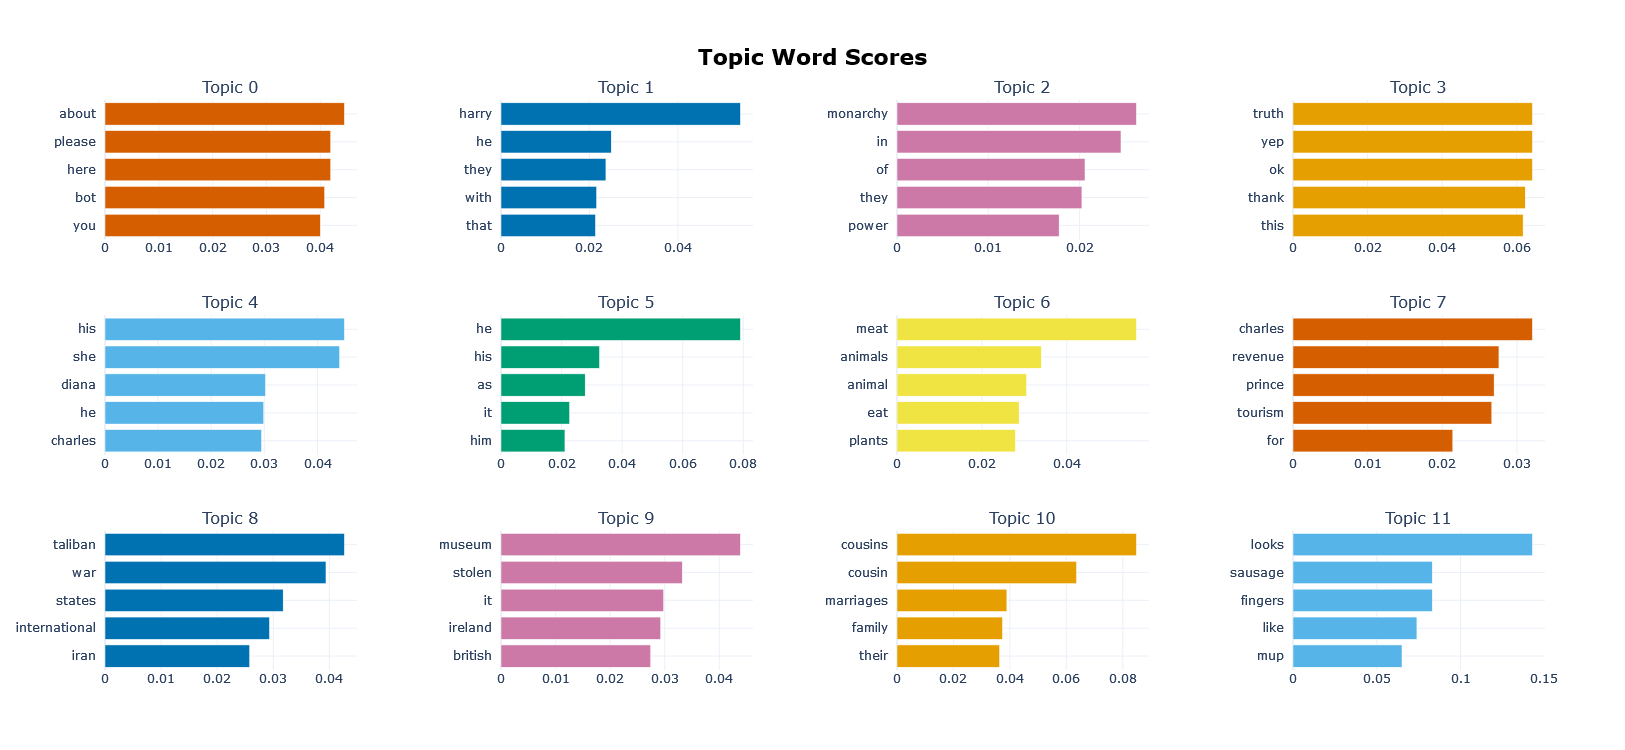

In [34]:
BERTopic_model.visualize_barchart(top_n_topics=12)

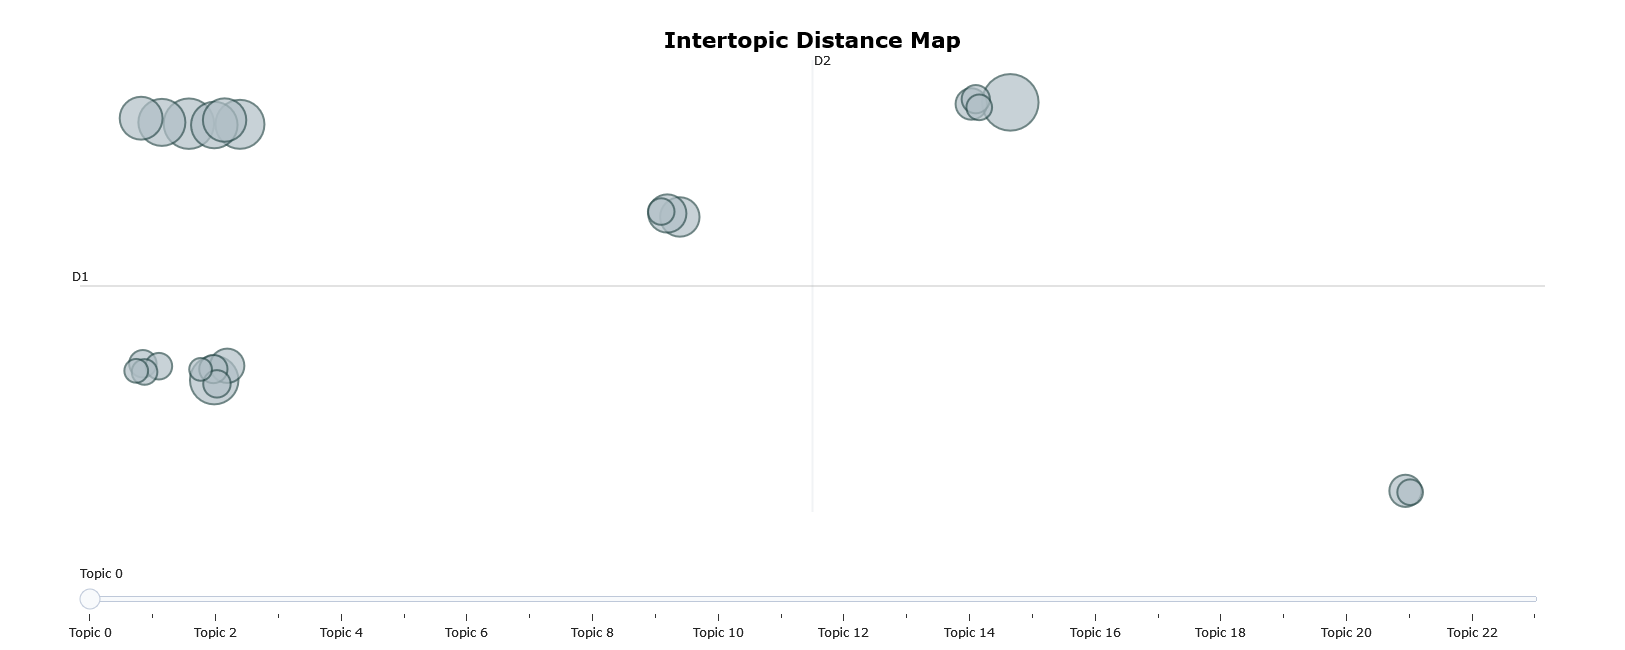

In [35]:
BERTopic_model.visualize_topics()

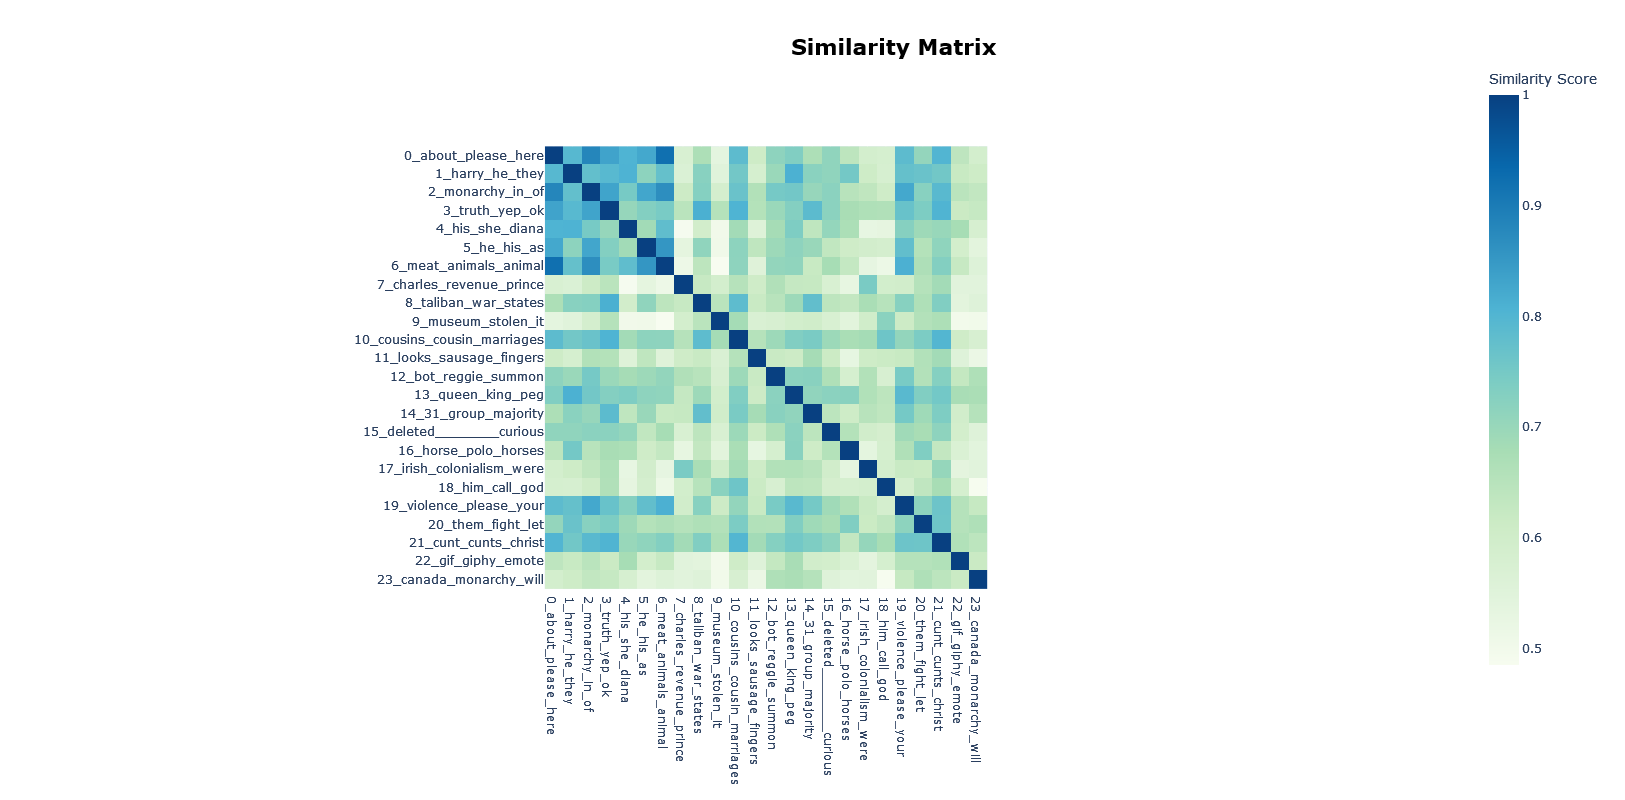

In [36]:
BERTopic_model.visualize_heatmap()

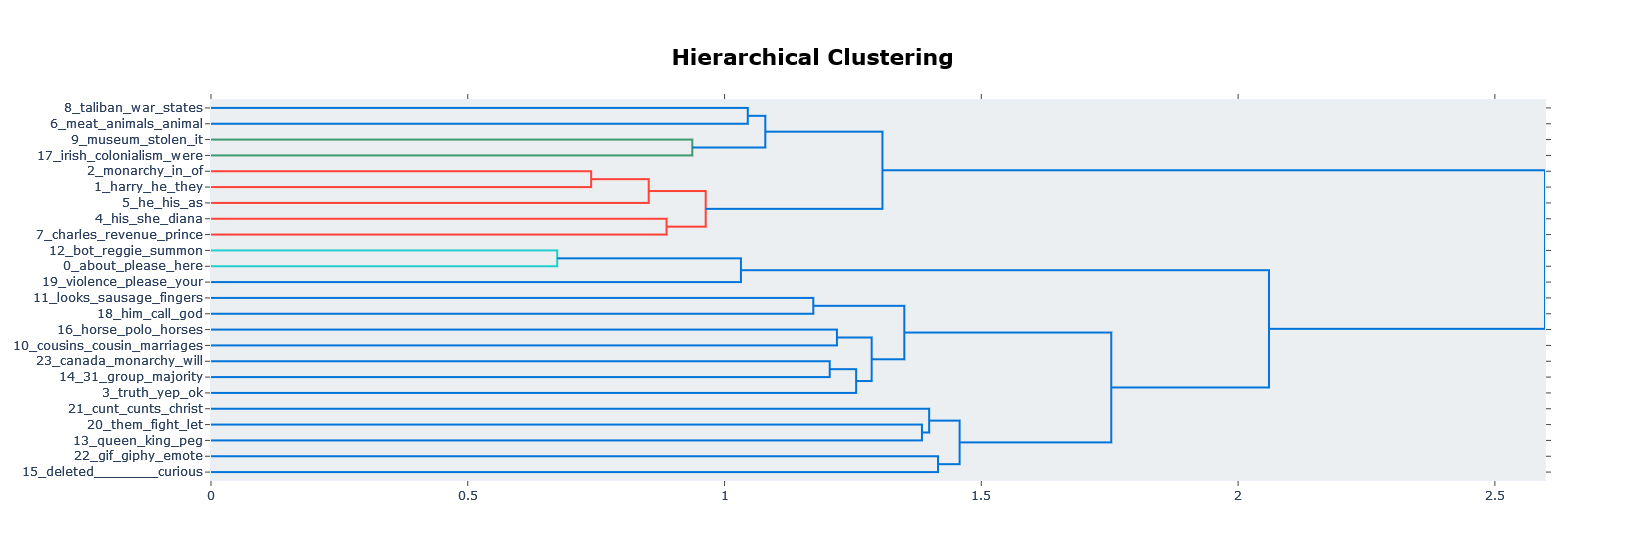

In [37]:
BERTopic_model.visualize_hierarchy(top_n_topics=100)

In [38]:
get_bert_topics(BERTopic_model, len(set(topics))-1)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,...,Topic # 15,Topic # 16,Topic # 17,Topic # 18,Topic # 19,Topic # 20,Topic # 21,Topic # 22,Topic # 23,Topic # 24
0,about,harry,monarchy,truth,his,he,meat,charles,taliban,museum,...,31,deleted,horse,irish,him,violence,them,cunt,gif,canada
1,please,he,in,yep,she,his,animals,revenue,war,stolen,...,group,______,polo,colonialism,call,please,fight,cunts,giphy,monarchy
2,here,they,of,ok,diana,as,animal,prince,states,it,...,majority,curious,horses,were,god,your,let,christ,emote,will
3,bot,with,they,thank,he,it,eat,tourism,international,ireland,...,age,proof,are,ancestors,don,post,re,jesus,free_emotes_pack,would
4,you,that,power,this,charles,him,plants,for,iran,british,...,high,im,spurs,us,title,theories,we,such,poop,abolishing
5,royal,his,are,what,andrew,all,people,abolished,bin,artefacts,...,polls,relevant,racing,american,emperor,unintentionally,track,fucking,pervy,it
6,any,is,is,lol,camilla,wants,are,public,laden,other,...,barely,what,sport,said,trump,content,clowns,what,garth,shot
7,fun,but,kings,wrong,her,this,for,in,united,they,...,wish,said,seen,ireland,see,antisemitic,clock,delusional,b86lxbrmsz0sq,canadian
8,or,press,that,thanks,that,though,vegan,crown,law,be,...,really,now,not,native,calling,reptilian,civil,learnt,warms,getting
9,if,book,king,you,was,can,eating,royal,afghanistan,can,...,then,very,animal,victims,king,intentionally,shagging,warmth,expletive,abolished


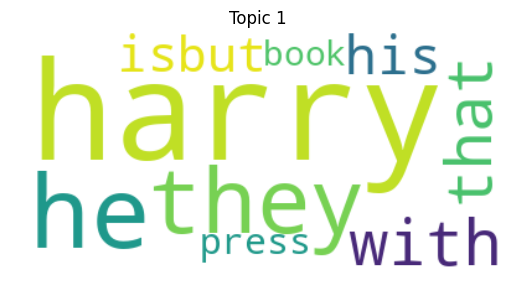

In [39]:
for i in range(1,2):
    create_wordcloud(BERTopic_model, topic=i)

# saving labels and matrix

In [40]:
labels = (BERTopic_model.get_topic_info().sort_values("Topic", ascending=True).Name)[1:]

In [41]:
np.shape(labels)

(24,)

In [42]:
sim_matrix = cosine_similarity(BERTopic_model.c_tf_idf_)

In [43]:
np.shape(sim_matrix)

(25, 25)

In [44]:
np.savetxt("incels1.csv", sim_matrix, delimiter=",")

# **updating paramters**

In [45]:
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 2), min_df=10)
BERTopic_model.update_topics(docs, topics, vectorizer_model=vectorizer_model, n_gram_range=(1, 2))

# visualizing data

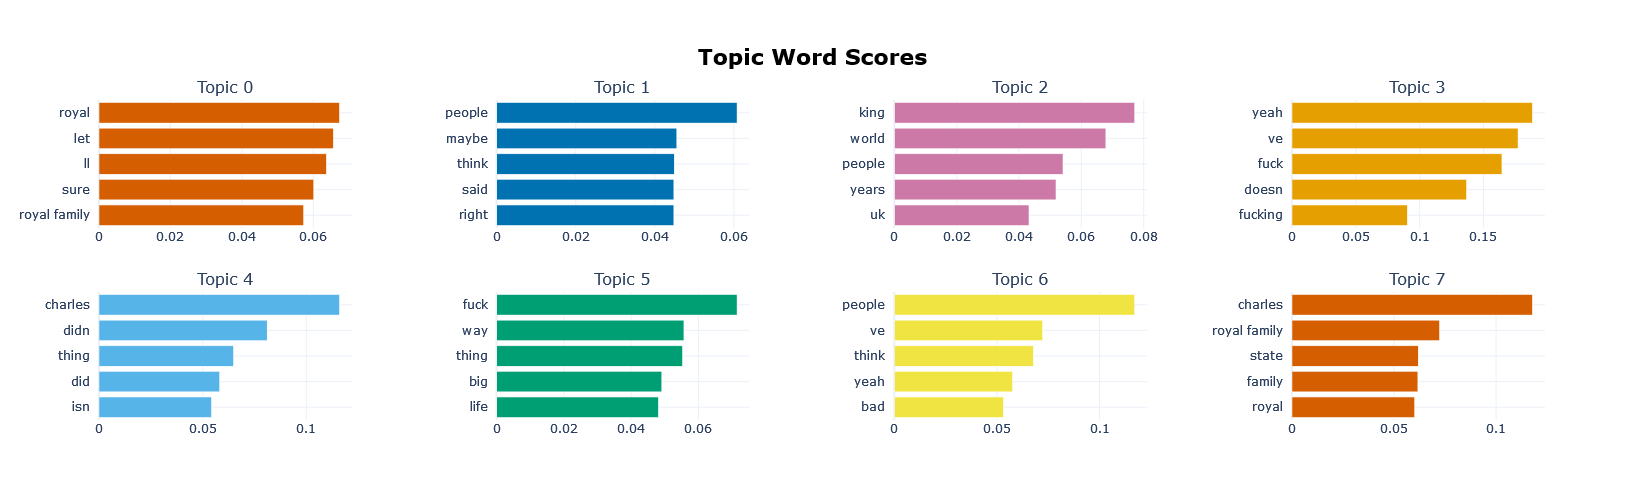

In [46]:
BERTopic_model.visualize_barchart()

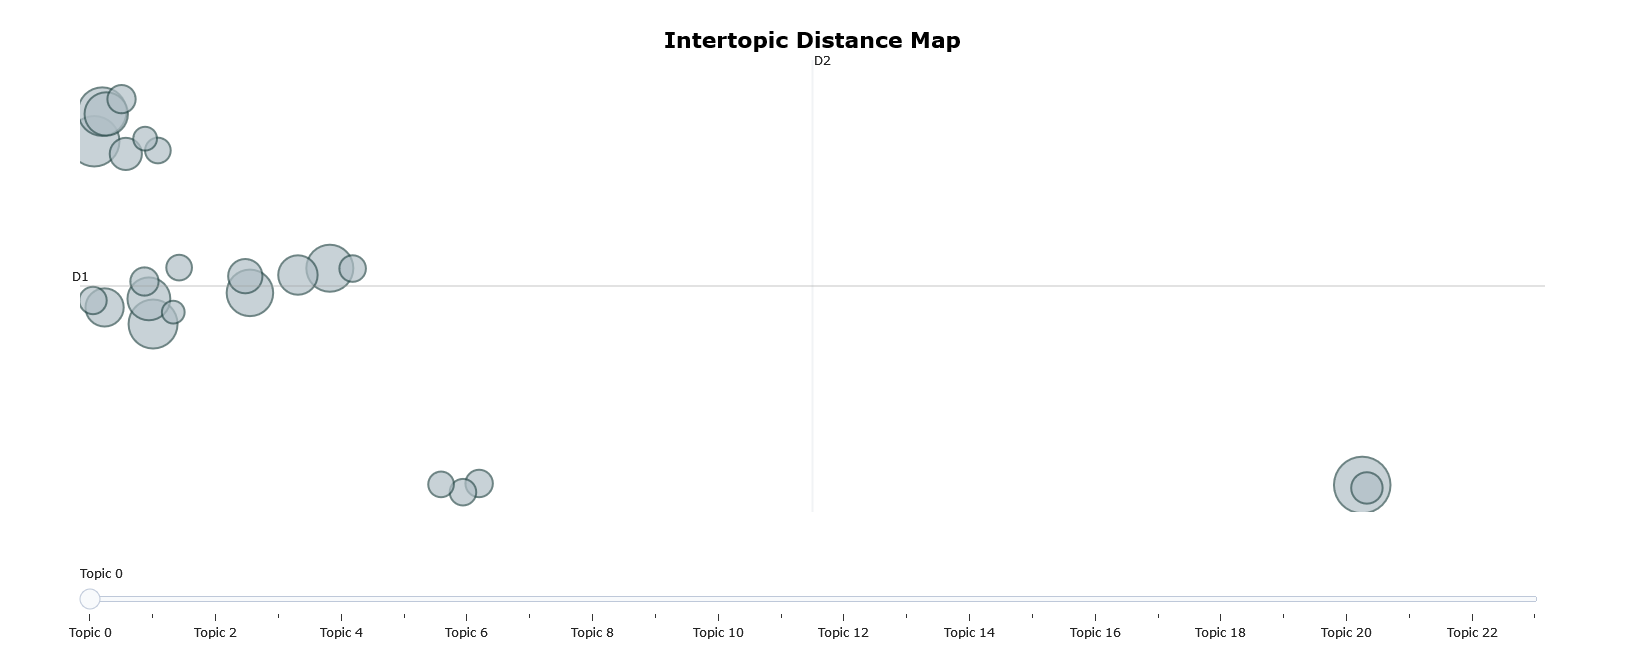

In [47]:
BERTopic_model.visualize_topics()

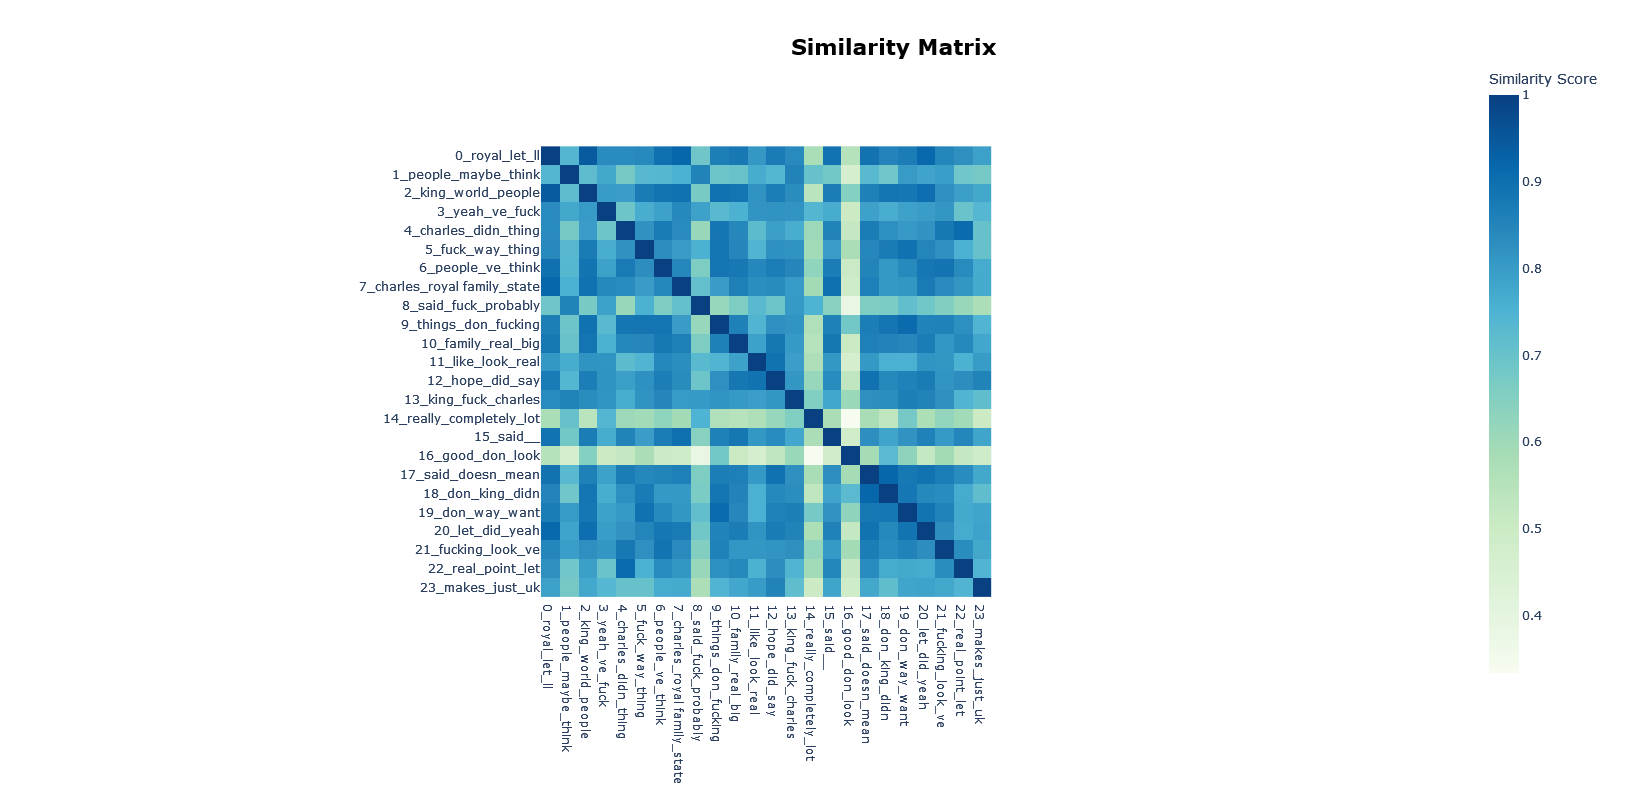

In [48]:
BERTopic_model.visualize_heatmap()

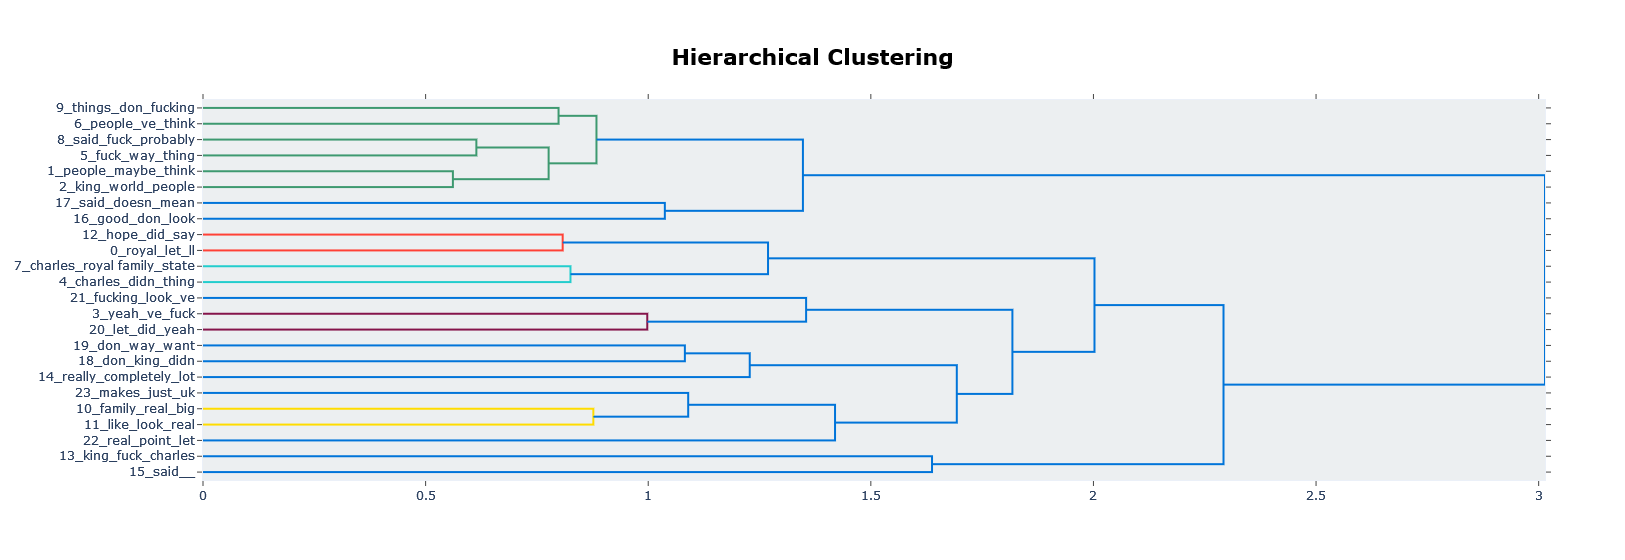

In [49]:
BERTopic_model.visualize_hierarchy(top_n_topics=30)

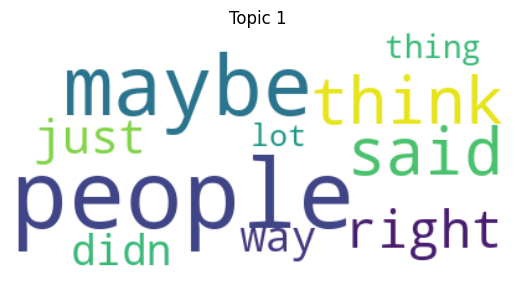

In [50]:
for i in range(1,2):
    create_wordcloud(BERTopic_model, topic=i)

# **reducing topics

In [51]:
BERTopic_model.reduce_topics(docs, nr_topics=50)

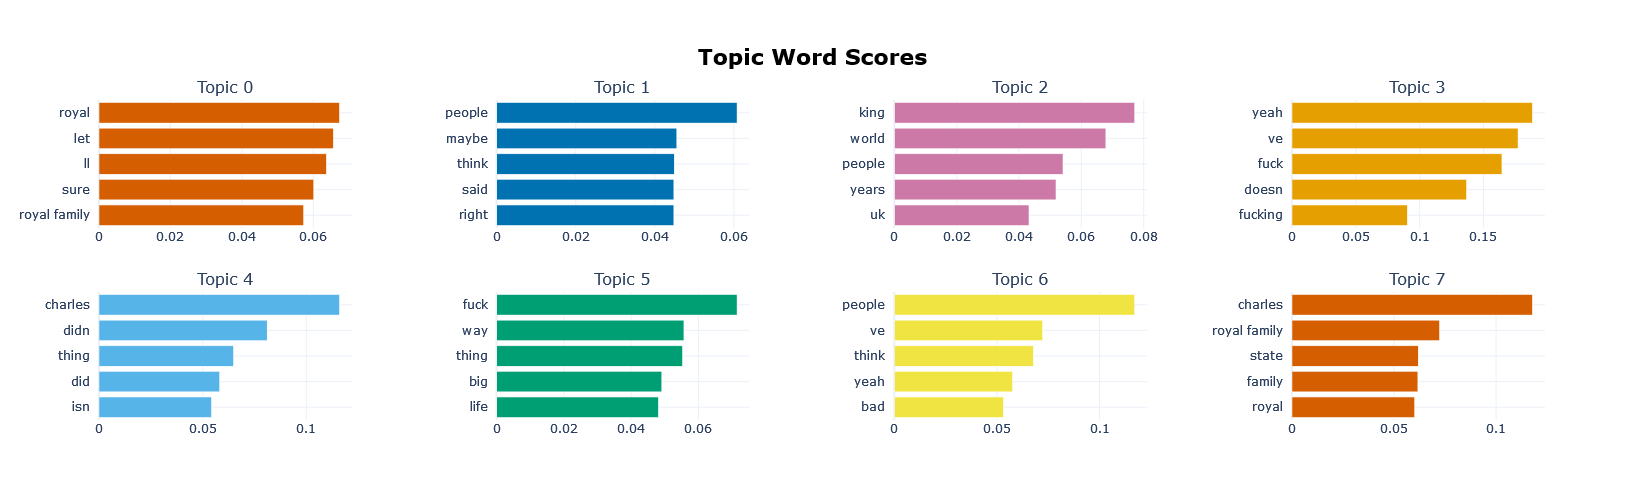

In [52]:
BERTopic_model.visualize_barchart()

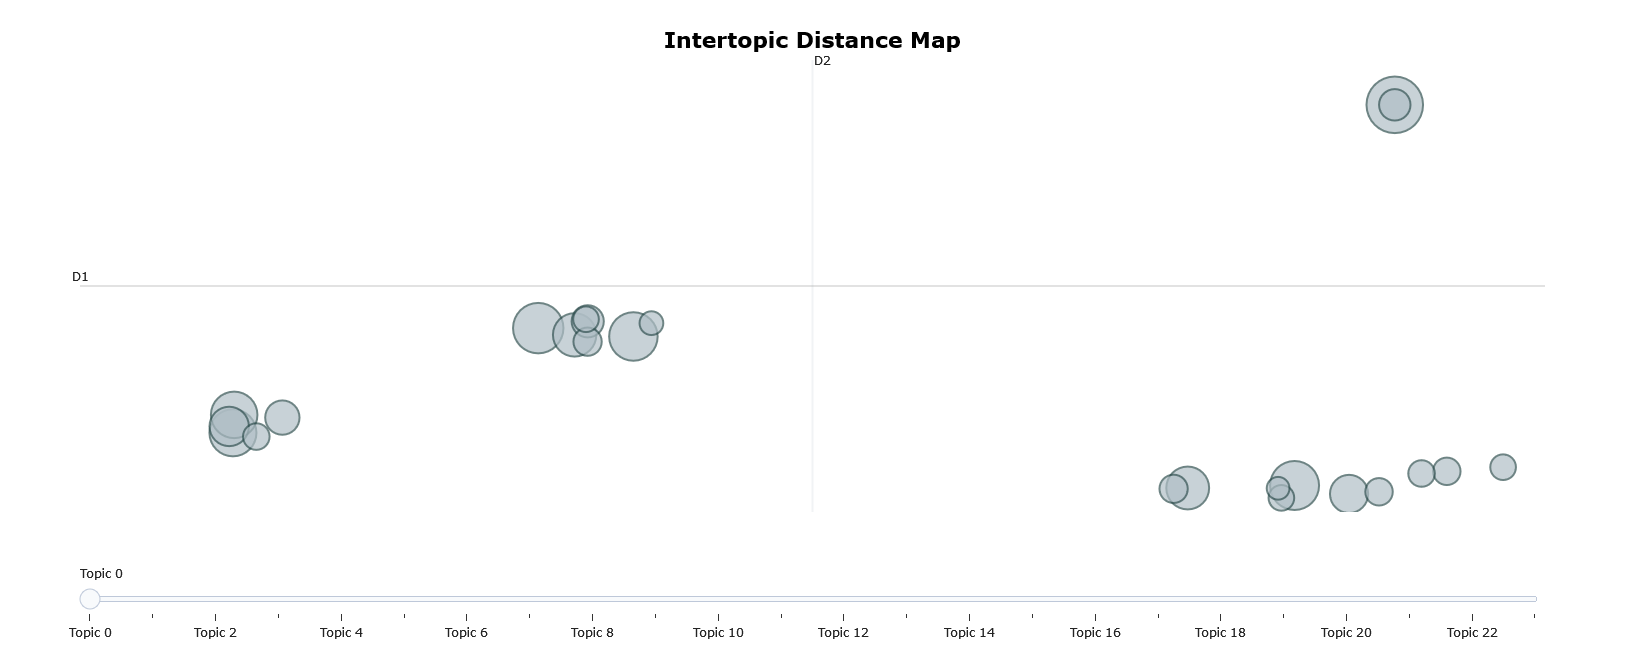

In [53]:
BERTopic_model.visualize_topics()

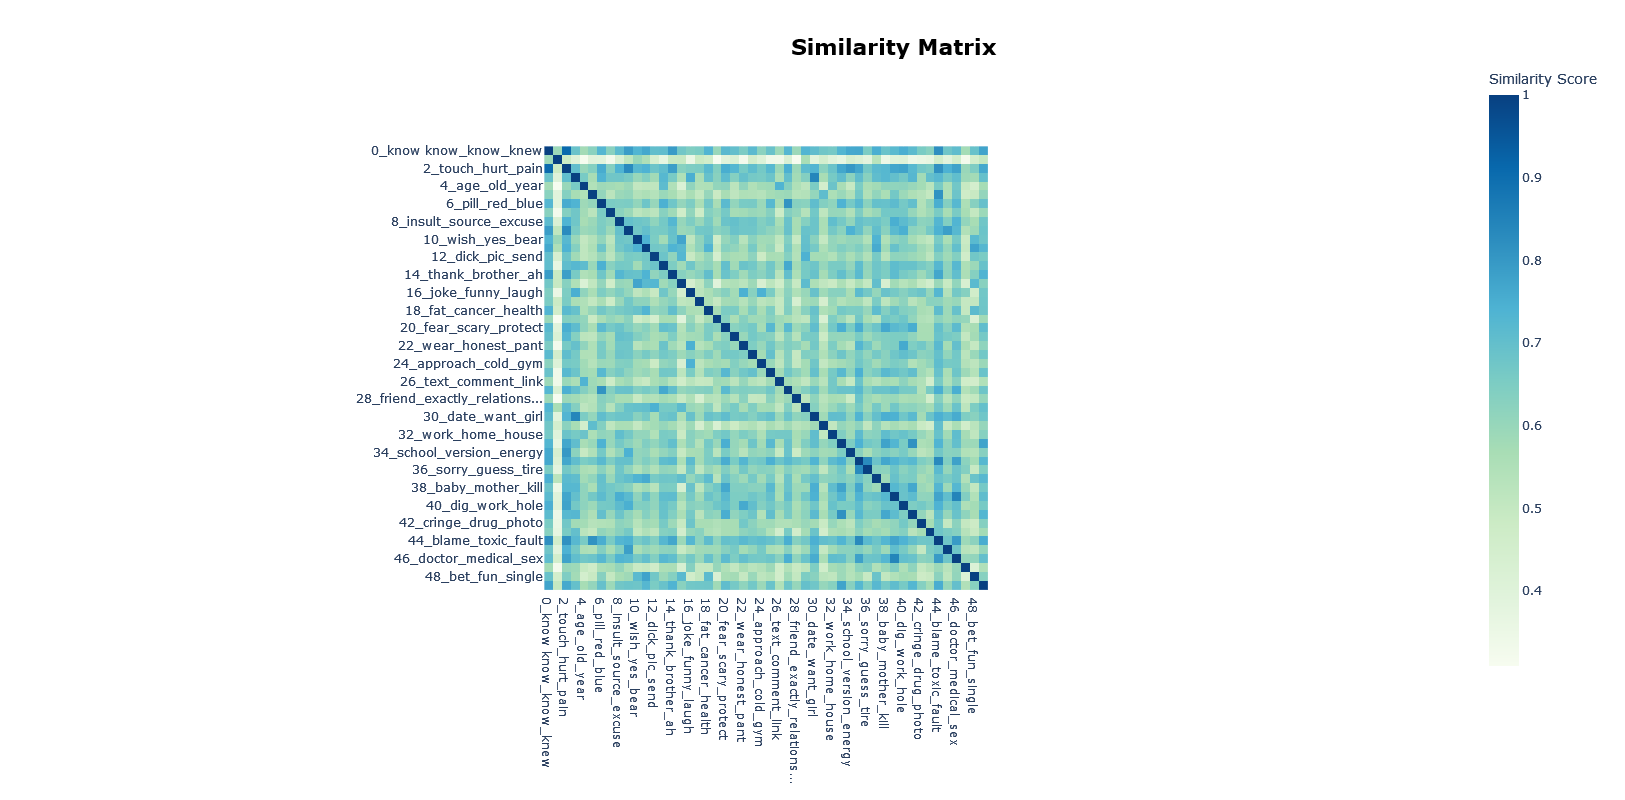

In [51]:
BERTopic_model.visualize_heatmap()

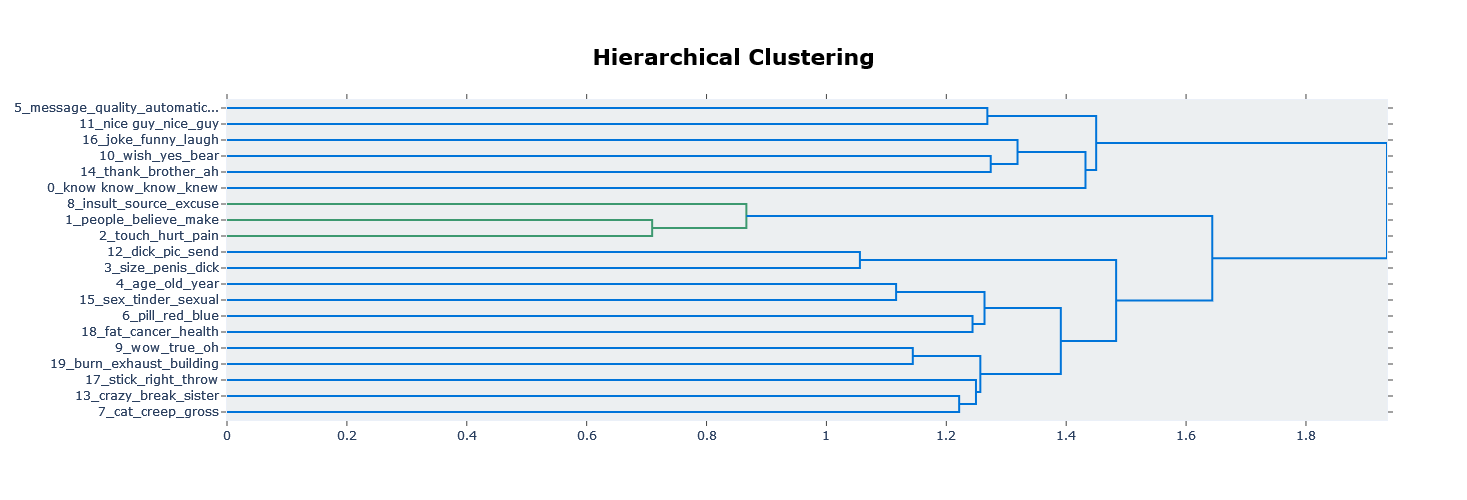

In [ ]:
BERTopic_model.visualize_hierarchy(top_n_topics=20)

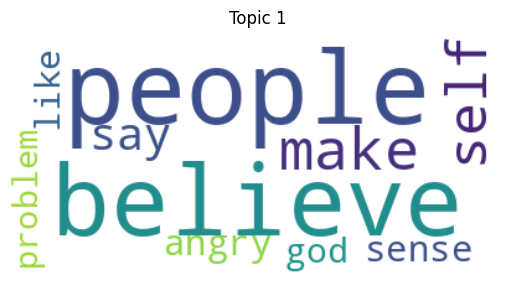

In [ ]:
for i in range(1,2):
    create_wordcloud(BERTopic_model, topic=i)

In [54]:
labels = (BERTopic_model.get_topic_info().sort_values("Topic", ascending=True).Name)[1:]

In [55]:
np.shape(labels)

(50,)

In [56]:
sim_matrix = cosine_similarity(BERTopic_model.c_tf_idf_)

In [57]:
np.shape(sim_matrix)

(51, 51)

In [58]:
sim_matrix[0,:]

array([1.        , 0.11189207, 0.8619431 , 0.61750374, 0.37476638,
       0.37044062, 0.14654051, 0.40185676, 0.31377212, 0.56272266,
       0.31040608, 0.26921875, 0.25399947, 0.2544946 , 0.32618425,
       0.18936057, 0.48853458, 0.24291739, 0.25656474, 0.35152088,
       0.44369663, 0.39173606, 0.42016246, 0.3079566 , 0.35111476,
       0.44354785, 0.30584978, 0.24963934, 0.29072337, 0.43739478,
       0.31520577, 0.36992302, 0.20262207, 0.43925729, 0.30724575,
       0.62129654, 0.55243303, 0.23212911, 0.39521865, 0.39222826,
       0.35480311, 0.46840707, 0.23890565, 0.25898096, 0.66417649,
       0.37593145, 0.33578133, 0.20397352, 0.18432612, 0.25024619,
       0.22251695])

# predictions

In [ ]:
# New data for the review
new_review = "I like the new headphone. Its sound quality is great."# Find topics
num_of_topics = 3
similar_topics, similarity = topic_model.find_topics(new_review, top_n=num_of_topics); # Print results
print(f'The top {num_of_topics} similar topics are {similar_topics}, and the similarities are {np.round(similarity,2)}')

NameError: name 'topic_model' is not defined

In [ ]:
# Print the top keywords for the top similar topics
for i in range(num_of_topics):
    print(f'The top keywords for topic {similar_topics[i]} are:')
    print(topic_model.get_topic(similar_topics[i]))

# TIPS

In [ ]:
topics_to_merge = [[1, 2]
                   [3, 4]]
topic_model.merge_topics(docs, topics_to_merge)

In [ ]:
similar_topics, similarity = topic_model.find_topics("motor", top_n=5)
topic_model.get_topic(similar_topics[0])

In [ ]:
topic_term_matrix = topic_model.c_tf_idf_
words = topic_model.vectorizer_model.get_feature_names()

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from keybert import KeyBERT

# Prepare documents 
docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']

# Extract keywords
kw_model = KeyBERT()
keywords = kw_model.extract_keywords(docs)

# Create our vocabulary
vocabulary = [k[0] for keyword in keywords for k in keyword]
vocabulary = list(set(vocabulary))

Then, we pass our vocabulary to BERTopic and train the model:

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model= CountVectorizer(vocabulary=vocabulary)
topic_model = BERTopic(vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(docs)

In [ ]:
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))
docs = data["data"]
targets = data["target"]
target_names = data["target_names"]
classes = [data["target_names"][i] for i in data["target"]]

Next, we want to extract the topics across all documents without taking the categories into account:

topic_model = BERTopic(verbose=True)
topics, probs = topic_model.fit_transform(docs)

Now that we have created our global topic model, let us calculate the topic representations across each category:

topics_per_class = topic_model.topics_per_class(docs, classes=classes)

The classes variable contains the class for each document. Then, we simply visualize these topics per class:

topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=10)